<h3>Imports and classes</h3>

RandomForestClassifier: n_estimators = 1200(树的数量)，class_weight = ' balanced '和criterion = ' entropy '

In [1]:
#!/usr/bin/env python
# coding: utf-8
%matplotlib inline
import os
import sys
import warnings
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import sample
import collections
from statistics import mean
from tqdm.notebook import tqdm

#对疏水值进行平滑处理
# Preprocessing
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
# Sklearn imports
from sklearn.utils import shuffle
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split


from sklearn.metrics import *

from sklearn.feature_selection import VarianceThreshold

# Different machine learning models from sklearn
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import average_precision_score

CWD = os.getcwd()
RANDOMSTATE = 42

class IuPred:
    '''
    Needs description.
    '''    
    def __init__(self, glob, short, long):
        self.glob = glob
        self.short = short
        self.long = long


class HydroPhobicIndex:
    '''
    Needs description.
    '''
    def __init__(self, hpilist):
        self.hpilist = hpilist

In [2]:
pip install scikit-learn

  Using cached scikit_learn-0.24.2-cp36-cp36m-win_amd64.whl (6.8 MB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
Note: you may need to restart the kernel to use updated packages.


<h3>Functions</h3>

In [2]:
def preprocess_data(df, scaler):
    info = df.select_dtypes(include=['object'])
    y = df[instance]
    X = df.drop([instance], axis=1)
    X = X._get_numeric_data()
    columns = X.columns
    
    X = scaler.fit_transform(X)    
    X = pd.DataFrame(X, columns=columns)
    X[instance] = y
    X = X.merge(info, how='outer', left_index=True, right_index=True)    
    return X

#
def remove_correlating_features(df, cutoff=.95, plot=False):#去除Pearson相关性低于0.95的特征。
    # Set matplotlib parameters
    sns.set(rc={'figure.figsize':(8,6)})
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    
    print('Correlation: Features before %s' % df.shape[1])
    
    # Create correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > cutoff)]
    # Drop features
    df = df.drop(to_drop, axis=1)
    
    
    print('Correlation: Features after %s' % df.shape[1])
    if plot:
        # Plot heatmap
        sns.set(rc={'figure.figsize':(11.7,8.27)})
        sns.heatmap(data=df.corr(), cmap=sns.color_palette("coolwarm", 20), vmin=-1, vmax=1)
        plt.savefig(os.getcwd()+ '\\data\graphs\\6.Heatmap_after_correlation.pdf', transparent=True)
        plt.show()
    return df


def varianceSelection(df, threashold=.8):
    if not isinstance(df, pd.core.frame.DataFrame):
        logger.error('[%s] : [ERROR] Variance selection only possible on Dataframe not %s',
                                     datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'), type(df))
        sys.exit(1)
    sel = VarianceThreshold(threshold=(threashold * (1 - threashold)))
    sel.fit_transform(df)
    return df[[c for (s, c) in zip(sel.get_support(), df.columns.values) if s]]


def filter_low_variance(df, non_feature_columns, variance_cutoff=.8):
    df_variancetreshold = varianceSelection(df.drop(non_feature_columns, axis=1), variance_cutoff)
    for col in non_feature_columns:
        df_variancetreshold[col] = df[col]
    return df_variancetreshold


def remove_low_variance_features(df, variance_cutoff, plot=False):
    print('Low varience: Features before %s' % df.shape[1])
    non_feature_columns = ['protein_name', 'sequence', 'llps']
    df_variance = filter_low_variance(df, non_feature_columns, variance_cutoff)
    print('Low varience: Features after  %s' % df_variance.shape[1])
    
    # Set matplotlib parameters
    if plot:
        sns.set(rc={'figure.figsize':(8,6)})
        plt.rcParams['pdf.fonttype'] = 42
        plt.rcParams['ps.fonttype'] = 42

        # Plot heatmap
        sns.set(rc={'figure.figsize':(11.7,8.27)})
        sns.heatmap(data=df_variance.corr(), cmap=sns.color_palette("coolwarm", 20), vmin=-1, vmax=1)

        plt.savefig(os.getcwd()+ '\\data\graphs\\6.heatmap_after_low_variance.pdf', transparent=True)
        plt.show()
    return df_variance


def get_feature_importances(df, clf):
    '''
    Needs description.
    '''    
    fi = clf.feature_importances_
    fi = pd.DataFrame(fi).transpose()
    fi.columns = df.columns[1:]
    fi = fi.melt()
    fi = fi.sort_values('value', ascending=False)
    fi = fi.loc[fi['value'] > 0.0]
    return fi


def select_testing_data(df, instance, ratio=1, info_columns=['protein_name', 'sequence'], random=False):
    '''
    Class that equalizes the data based on the number of positives.
    :param df: dataframe with all the features and instance
    :param instance: string of instance columns
    :param ratio: ratio of how many negatives should be added (2 = twice as much negative)
    :param random: bool which gives a random test set with both instances randomly picked.
    :return: 'out' dataframe with new data, and 'df_info' dataframe with the information of 
    protein name and sequence.
    '''
    pos = df.loc[df[instance] == 1]
    neg_index = df.loc[df[instance] == 0].index
    negsubset_index = sample(set(neg_index), len(pos) * ratio)
    if random:
        possubset_index = sample(set(df.index), len(pos))
        negsubset_index = sample(set(df.index), len(pos))
        pos = df.loc[possubset_index]
        pos[instance] = pos[instance] = 1
    neg = df.loc[negsubset_index]
    out = pos.append(neg)
    out = out.reset_index(drop=True)
    df_info = out[info_columns]
    out = out.drop(labels=info_columns, axis=1)
    return out, df_info


def calculate_performance(clf, X_test, y_test):
    '''
    Needs description.
    '''    
    prediction = clf.predict(X_test)
    correctness = prediction == y_test
    distribution = correctness.value_counts(True)
    return distribution


def train_model(data, clf, instance):
    df, df_info = select_testing_data(data, instance, ratio=1, random=False)
    X_train, X_test, y_train, y_test = train_test_split(df.drop(instance, axis=1),
                                                        df[instance],
                                                        test_size=0.5,
                                                        random_state=RANDOMSTATE,
                                                        )
    clf = clf.fit(X_train, y_train)
    return clf, X_test, y_test

    
def plot_pca(df, title='', analysis_name=''):
    # Set matplotlib parameters
    sns.set(rc={'figure.figsize':(8,6)})
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(df.drop(['sequence', 'protein_name'],axis=1))
    pca_df = pd.DataFrame(X_pca, columns=['component1', 'component2'])
    pca_df['protein_name'] = df['protein_name']
    pca_df['llps'] = df.reset_index()['llps']


    sns.scatterplot(data=pca_df.loc[pca_df['llps'] == 0],
                    x = 'component1',
                    y = 'component2',
                    alpha = .5,
                    color = '#AEB6BF',
                    rasterized=True,
                   )
    sns.scatterplot(data=pca_df.loc[pca_df['llps'] == 1],
                    x = 'component1',
                    y = 'component2',
                    alpha = 1,
                    color = '#CD6155',                
                   )
    
    
    # print(pca_df.loc[(pca_df['llps'] == 1) & (pca_df['component1'] >= 650)])
    
    plt.ylabel('Component1 (' + str(round(pca.explained_variance_ratio_[0] * 100, 2)) + '%)')
    plt.xlabel('Component2 (' + str(round(pca.explained_variance_ratio_[1] * 100, 2)) + '%)')
    plt.title(title)
    plt.savefig(os.getcwd()+ f'\\analysis\\{analysis_name}\\PCA_plot.pdf', transparent=True)
    plt.show()


def average(l):
    return sum(l) / len(l)

<h1>1. Data processing and feature selection </h1>

In [33]:
def preprocess_and_scaledata(data, instance):
    try:
        data = data.drop(['iupred', 'HydroPhobicIndex', 'uniprot_id', 'PRDaa'], axis=1)
    except KeyError:
        data = data.drop(['iupred', 'HydroPhobicIndex', 'uniprot_id'], axis=1)
    data = data.fillna(value=0)
    print(data.shape)
    print('Number of phase separating proteins in dataset: '+str(data.loc[data[instance] == 1].shape[0]))
    print(data.shape)
    
    # scaler = QuantileTransformer(output_distribution='normal')
    scaler = QuantileTransformer()
    df = data.copy()
    processed_data = df.fillna(0)
    processed_data = preprocess_data(processed_data, scaler)
    #processed_data = remove_correlating_features(processed_data, cutoff=.95)
    #processed_data = remove_low_variance_features(processed_data, variance_cutoff=0.08)
    return processed_data

In [34]:
path = os.getcwd()+'/data/Dataframes/total.pkl'
data = pd.read_pickle(path)
data

,protein_name,uniprot_id,sequence,fraction_A,fraction_C,fraction_D,fraction_E,fraction_F,fraction_G,fraction_H,...,V_lcscore,V_lcfraction,W_lcscore,W_lcfraction,Y_lcscore,Y_lcfraction,lcs_fractions,lcs_scores,lcs_lowest_complexity,llps
0,CBPB2_HUMAN,Q96IY4,MKLCSLAVLVPIVLFCEQHVFAFQSGQVLAALPRTSRQVQVLQNLT...,0.068558,0.023641,0.040189,0.056738,0.042553,0.047281,0.037825,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,9,0
1,CCL1_HUMAN,P22362,MQIITTALVCLLLAGMWPEDVDSKSMQVPFSRCCFSFAEQEIPLRA...,0.062500,0.072917,0.031250,0.052083,0.041667,0.041667,0.020833,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,10,0
2,CLRN3_HUMAN,Q8NCR9,MPTTKKTLMFLSSFFTSLGSFIVICSILGTQAWITSTIAVRDSASN...,0.044248,0.004425,0.008850,0.039823,0.079646,0.061947,0.013274,...,NaN,NaN,NaN,NaN,NaN,NaN,0.053097,12,7,0
3,CBLN2_HUMAN,Q8IUK8,MQAPGRGPLGLRLMMPGRRGALREPGGCGSCLGVALALLLLLLPAC...,0.075893,0.026786,0.035714,0.040179,0.044643,0.098214,0.017857,...,2.0,0.076923,0.0,0.000000,0.0,0.0,0.214286,48,6,0
4,CARD6_HUMAN,Q9BX69,MATESTPSEIIERERKKLLEILQHDPDSILDTLTSRRLISEEEYET...,0.055931,0.022179,0.045323,0.085824,0.048216,0.055931,0.023144,...,3.0,0.069767,1.0,0.023256,0.0,0.0,0.061716,64,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20375,FBLI1_HUMAN,Q8WUP2,MASKPEKRVASSVFITLAPPRRDVAVAEEVRQAVCEARRGRPWEAP...,0.099196,0.072386,0.045576,0.077748,0.034853,0.058981,0.021448,...,3.0,0.120000,0.0,0.000000,0.0,0.0,0.123324,46,4,0
20376,FGF2_HUMAN,P09038,MVGVGGGDVEDVTPRPGGCQISGRGARGCNGIPGAAAWEAALPRRR...,0.097222,0.020833,0.034722,0.045139,0.027778,0.163194,0.013889,...,1.0,0.018868,0.0,0.000000,0.0,0.0,0.253472,73,5,0
20377,GLI3_HUMAN,P10071,MEAQSHSSTTTEKKKVENSIVKCSTRTDVSEKAVASSTTSNEDESP...,0.070886,0.018354,0.044937,0.047468,0.021519,0.077215,0.042405,...,NaN,NaN,NaN,NaN,NaN,NaN,0.007595,12,7,1
20378,GLPK_HUMAN,P32189,MAASKKAVLGPLVGAVDQGTSSTRFLVFNSKTAELLSHHQVEIKQE...,0.075134,0.026834,0.033989,0.066190,0.037567,0.084079,0.017889,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,8,0


In [9]:
data.columns

Index(['protein_name', 'uniprot_id', 'sequence', 'fraction_A', 'fraction_C',
       'fraction_D', 'fraction_E', 'fraction_F', 'fraction_G', 'fraction_H',
       'fraction_I', 'fraction_K', 'fraction_L', 'fraction_M', 'fraction_N',
       'fraction_P', 'fraction_Q', 'fraction_R', 'fraction_S', 'fraction_T',
       'fraction_V', 'fraction_W', 'fraction_Y', 'length', 'IEP',
       'molecular_weight', 'gravy', 'iupred', 'HydroPhobicIndex',
       'idr_percetage', 'idr_50', 'idr_60', 'idr_70', 'idr_80', 'idr_90',
       'hpi_<-1.5_frac', 'hpi_<-2.0_frac', 'hpi_<-2.5_frac', 'hpi_<-1.5',
       'hpi_<-2.0', 'hpi_<-2.5', 'Asx', 'Glx', 'Xle', 'Pos_charge',
       'Neg_charge', 'Aromatic', 'Alipatic', 'Small', 'Hydrophilic',
       'Hydrophobic', 'alpha_helix', 'beta_turn', 'beta_sheet', 'aromaticity',
       'A_lcscore', 'A_lcfraction', 'C_lcscore', 'C_lcfraction', 'D_lcscore',
       'D_lcfraction', 'E_lcscore', 'E_lcfraction', 'F_lcscore',
       'F_lcfraction', 'G_lcscore', 'G_lcfraction', '

In [35]:
path = 'data/Dataframes/total.pkl'
data = pd.read_pickle(path)
instance = 'llps'
data = data.loc[(data['length'] >= 100) & (data['length'] <= 3000)]
data = data.reset_index(drop=True)
domain_cols = data.columns[data.columns.str.contains("^domain")]
print(data.columns.str.contains("^domain"))
domain_data = data[domain_cols]
data.drop(columns=domain_cols)
data = preprocess_and_scaledata(data, instance)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
(19497, 96)
Number of phase separating proteins in dataset: 89
(19497, 96)


# Test method

In [36]:
class EnsembleRandomForest:
    def __init__(self):
        self.estimators = list()

    def fit(self, data, index_list, label):
        estimators=list()   
        non_numeric_columns = (list(data.select_dtypes(include='object')))
        data = data.select_dtypes([np.number])
        for index in tqdm(index_list):
            df = data.loc[index]
            X = df.drop(instance, axis=1)
            y = df[label]
            clf = RandomForestClassifier()
            clf.fit(X, y)
            estimators.append(clf)
        self.estimators = estimators

    def predict_proba(self, df, label):
        probabilities = list()
        for clf in self.estimators:
            probability = clf.predict_proba(df)[:,1]
            probabilities.append(probability)
        probabilities = np.array(probabilities)
        predictions = list()
        for i in range(probabilities.shape[1]):
            prediction = np.average(probabilities[:,i])
            predictions.append(prediction)
        return predictions

In [37]:
def split_dataframe_data(data, label, n=30, n_negative=30):
    positive_label_sample = data[data[label] == 1].sample(n)
    negative_label_sample = data[data[label] == 0].sample(n_negative)
    train_data = data.drop(list(positive_label_sample.index))
    train_data = train_data.drop(list(negative_label_sample.index))
    test_data = shuffle(positive_label_sample.append(negative_label_sample)).reset_index(drop=True)      
    return train_data, test_data,

### K-Fold cross validation

Updated: 
* Now uses `StratifiedKfold` for better selection of positives/negatives per fold.
* 10-fold cross-validation.


In [38]:
from sklearn.model_selection import StratifiedKFold

In [39]:
label = 'llps'
data_filtered = data.select_dtypes([np.number])
X = data_filtered.drop(label, axis=1)
y = data_filtered[label]
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

  0%|          | 0/10 [00:00<?, ?it/s]

Fold 1 ROC AUC: 0.9705
Fold 2 ROC AUC: 0.8157
Fold 3 ROC AUC: 0.9841
Fold 4 ROC AUC: 0.7875
Fold 5 ROC AUC: 0.7526
Fold 6 ROC AUC: 0.9680
Fold 7 ROC AUC: 0.9352
Fold 8 ROC AUC: 0.9386
Fold 9 ROC AUC: 0.9058
Fold 10 ROC AUC: 0.8215


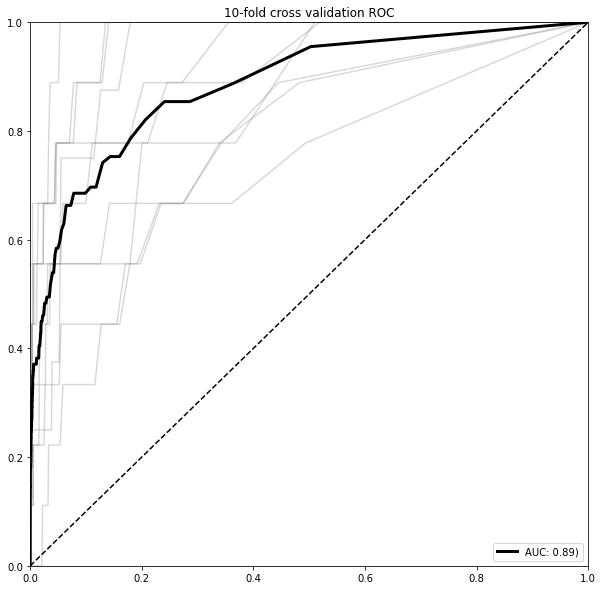

In [40]:
clf = RandomForestClassifier(n_jobs=32, class_weight="balanced", n_estimators=1200, criterion="entropy")
#clf = XGBClassifier(n_jobs=24, scale_pos_weight)
all_y_test = list()
all_y_proba = list()
all_idx = list()
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)  
all_aucs = []
for i, (train_index, test_index) in tqdm(enumerate(kf.split(X, y)), total=kf.n_splits):
    all_idx.extend(test_index)
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    #print(y_train.head())
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)[:,1]
    # scores individual
    fpr, tpr, _ = roc_curve(y_test, y_proba)
     
    
    all_y_test.extend(y_test)
    all_y_proba.extend(y_proba)
    
    roc_auc = auc(fpr, tpr)
    print(f"Fold {i + 1} ROC AUC: {roc_auc:.4f}")
    all_aucs.append(roc_auc)
  
    plt.plot(fpr, tpr, color="grey", alpha=0.3)
        
fpr, tpr, _ = roc_curve(all_y_test, all_y_proba)
    
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC: {roc_auc:.2f})', color="black", lw=3)

plt.title(f'{kf.n_splits}-fold cross validation ROC')    
plt.plot([0, 1], [0, 1], 'k--')
ax.legend(loc="lower right")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

#print("Mean AUC", np.mean(all_aucs))

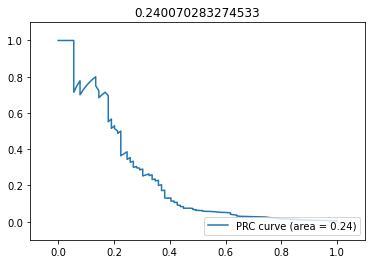

In [11]:
ax = plt.subplot(111)
average_precision = average_precision_score(all_y_test, all_y_proba)
precision, recall, _ = precision_recall_curve(all_y_test, all_y_proba)

plt.title('Precision Recall Curve')
ax.plot(recall, precision, label=f'PRC curve (area = {round(average_precision,2)})')
plt.title(str(average_precision))

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
ax.legend(loc="lower right")


# Compare P-score predictor

Comparison to Vernon et al. 2018 (https://elifesciences.org/articles/31486).

In [42]:
uniprot_ids = '''
Q99700
O60885
Q14781
P45973
P38432
Q7Z5Q1
O00571
Q9NQI0
O43781
Q04637
Q15056
P15502
Q01844
P22087
Q06787
P35637
Q13283
Q9UN86
P10071
P62993
Q13151
P09651
Q32P51
P22626
P51991
O14979
P31943
P55795
P31942
O43561
P10636
P43243
Q15648
P19338
P06748
Q15233
P52948
Q01860
P11940
P29590
Q8WXF1
Q96PK6
P98179
P23246
Q16637
P00441
Q07889
P23497
Q07955
Q01130
O95793
O75683
Q92804
Q13148
Q15554
P31483
Q01085
Q9UHD9
P46937
Q15059
P10644
P54727
Q13501
Q9NPI6
O00444
Q53HL2
Q9ULW0
Q9Y6A5
Q96LT7
P06748
Q16236
O43823
Q07157
Q9UDY2
O95049
Q9Y6M1
Q6NT89
Q8NC56
P04150
Q9BYJ9
Q9Y5A9
Q7Z739
P10997
Q9GZV5
P51608
O14979
P43351
Q08379
P08621
Q15424
Q16630
P18615
P48443
'''

uniprot_ids = uniprot_ids.strip().split("\n")

In [16]:
pscore_file = "./pscore2.out"
pscore = pd.read_table(pscore_file, sep=" +", usecols=[1,2], names=["score", "protein_id"])
pscore["uniprot_id"] = pscore["protein_id"].str.split("|", expand=True)[1]
pscore["llps"] = pscore["uniprot_id"].isin(uniprot_ids)


C:\Users\zjyu\AppData\Local\Temp\ipykernel_24780\3981148072.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pscore = pd.read_table(pscore_file, sep=" +", usecols=[1,2], names=["score", "protein_id"])


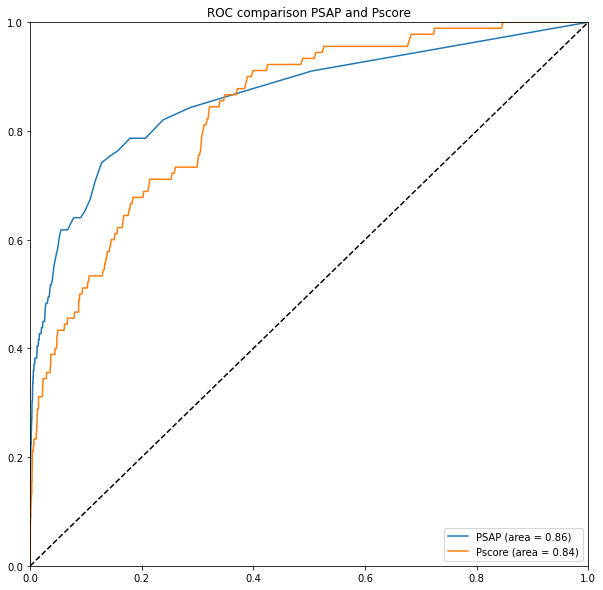

In [17]:
fpr, tpr, _ = roc_curve(all_y_test, all_y_proba)
fpr_pscore, tpr_pscore, _ = roc_curve(pscore["llps"], pscore["score"])


roc_auc = auc(fpr, tpr)
roc_auc_pscore = auc(fpr_pscore, tpr_pscore)
plt.figure(figsize=(10, 10))
ax = plt.subplot(111) 

plt.plot(fpr, tpr, label=f'PSAP (area = {roc_auc:.2f})')
plt.plot(fpr_pscore, tpr_pscore, label=f'Pscore (area = {roc_auc_pscore:.2f})')

plt.title('ROC comparison PSAP and Pscore')
ax.legend(loc="lower right")
plt.xlim([0, 1])
plt.ylim([0, 1])


plt.plot([0, 1], [0, 1], 'k--')
plt.show()

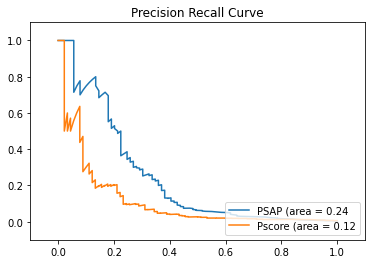

In [18]:
ax = plt.subplot(111)
average_precision = average_precision_score(all_y_test, all_y_proba)
precision, recall, _ = precision_recall_curve(all_y_test, all_y_proba)

average_precision_pscore = average_precision_score(pscore["llps"], pscore["score"])
precision_pscore, recall_pscore, _ = precision_recall_curve(pscore["llps"], pscore["score"])

plt.title('Precision Recall Curve')
ax.plot(recall, precision, label=f'PSAP (area = {average_precision:.2f}')
ax.plot(recall_pscore, precision_pscore, label=f'Pscore (area = {average_precision_pscore:.2f}')

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
ax.legend(loc="lower right")


# Train final model

And predict values for complete proteome.

In [19]:
clf = RandomForestClassifier(n_jobs=32, class_weight="balanced", n_estimators=1200, criterion="entropy", random_state=42)
clf.fit(X, y)
psap_prediction = pd.DataFrame(index=data["protein_name"])
psap_prediction["PSAP_score"] = clf.predict_proba(X)[:,1]

psap_prediction["llps"] = y.values
psap_prediction["rank"] = 0  
rank = psap_prediction.loc[psap_prediction["llps"] == 0, "PSAP_score"].rank(ascending=False)
psap_prediction["rank"] = rank

In [20]:
psap_prediction.loc[["FXR2_HUMAN", "ILF3_HUMAN", "YBOX1_HUMAN", "THOC4_HUMAN", "TFG_HUMAN"]]

,PSAP_score,llps,rank
protein_name,,,
FXR2_HUMAN,0.079167,0,7.0
ILF3_HUMAN,0.045833,0,46.5
YBOX1_HUMAN,0.062500,0,20.5
THOC4_HUMAN,0.064167,0,18.0
TFG_HUMAN,0.026667,0,117.5


In [21]:
psap_prediction.loc[["GORS1_HUMAN", "TCPB_HUMAN", "NRG4_HUMAN", "LIMK2_HUMAN", "MYO1C_HUMAN"]]

,PSAP_score,llps,rank
protein_name,,,
GORS1_HUMAN,0.001667,0,3709.0
TCPB_HUMAN,0.000833,0,5705.0
NRG4_HUMAN,0.000000,0,13243.5
LIMK2_HUMAN,0.000000,0,13243.5
MYO1C_HUMAN,0.000000,0,13243.5
